In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert the grayscale image to RGB
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),  # Convert the image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # VGG mean/std
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}


In [ ]:
data_dir = '/home/aishwaryakunche/DL project'
train_dir = os.path.join(data_dir, 'training')
val_dir = os.path.join(data_dir, 'testing')

In [ ]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
}

# Create DataLoaders with a batch size of 32
batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False),
}

In [ ]:
num_classes = len(image_datasets['train'].classes)

In [ ]:
model = models.vgg19(pretrained=True)  # Using pre-trained weights
print(f"Number of training images: {len(image_datasets['train'])}")
print(f"Number of validation images: {len(image_datasets['val'])}")

/home/aishwaryakunche/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aishwaryakunche/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/aishwaryakunche/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|████████████████████████████████████████| 548M/548M [00:45<00:00, 12.5MB/s]


Number of training images: 2870
Number of validation images: 394


In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss() # Define the loss function
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001) #optimizer

In [ ]:
num_epochs = 20

In [ ]:
train_loss_history = []
val_loss_history = []


def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            for inputs, labels in dataloaders[phase]: # Iterate over data
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_labels.extend(labels.cpu().numpy()) # Collect all labels and predictions for F1 scores
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            #F1 Score
            f1 = f1_score(all_labels, all_preds, average='weighted')
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {f1:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts) # Loading the best model weights
    return model

Epoch 1/20
----------
train Loss: 1.0225 Acc: 0.6310 F1: 0.6295
val Loss: 1.3827 Acc: 0.6142 F1: 0.5809

Epoch 2/20
----------
train Loss: 0.6887 Acc: 0.8136 F1: 0.8129
val Loss: 1.7970 Acc: 0.6421 F1: 0.5913

Epoch 3/20
----------
train Loss: 0.5514 Acc: 0.8599 F1: 0.8600
val Loss: 1.0970 Acc: 0.7716 F1: 0.7478

Epoch 4/20
----------
train Loss: 0.4275 Acc: 0.8969 F1: 0.8969
val Loss: 1.2063 Acc: 0.7690 F1: 0.7524

Epoch 5/20
----------
train Loss: 0.3811 Acc: 0.9185 F1: 0.9185
val Loss: 1.7674 Acc: 0.7919 F1: 0.7750

Epoch 6/20
----------
train Loss: 0.3786 Acc: 0.9146 F1: 0.9146
val Loss: 2.7868 Acc: 0.7411 F1: 0.7241

Epoch 7/20
----------
train Loss: 0.4336 Acc: 0.9143 F1: 0.9142
val Loss: 2.0881 Acc: 0.8452 F1: 0.8332

Epoch 8/20
----------
train Loss: 0.3746 Acc: 0.9341 F1: 0.9341
val Loss: 3.3564 Acc: 0.7843 F1: 0.7573

Epoch 9/20
----------
train Loss: 0.4049 Acc: 0.9394 F1: 0.9394
val Loss: 3.0684 Acc: 0.7868 F1: 0.7720

Epoch 10/20
----------
train Loss: 0.3831 Acc: 0.9422 F

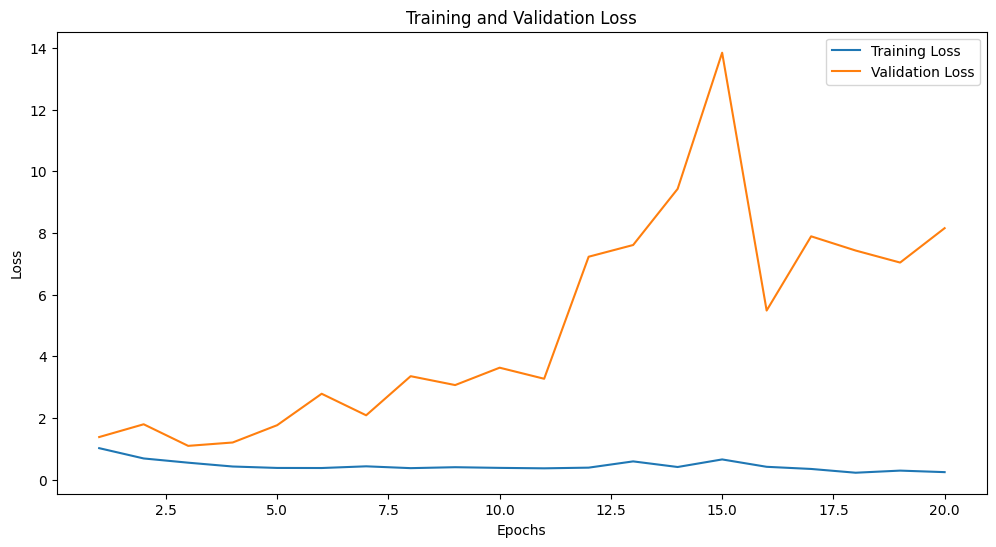

Final Accuracy on Validation Set: 85.28%


<Figure size 800x800 with 0 Axes>

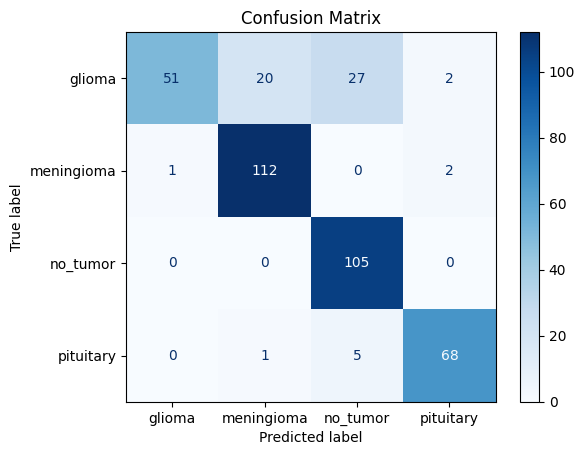

In [ ]:
best_model = train_model(model, criterion, optimizer, num_epochs)

# Saving trained model
torch.save(best_model.state_dict(), 'vgg19_fine_tuned.pth')


plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluating on validation set and calculate confusion matrix
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

#overall accuracy
correct = sum(p == t for p, t in zip(all_preds, all_labels))
total = len(all_labels)
final_accuracy = correct / total
print(f'Final Accuracy on Validation Set: {final_accuracy * 100:.2f}%')

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=image_datasets['val'].classes)
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()